# EECS 731 Project 6: Anomaly Detection
## By Matthew Taylor

### Import required modules

In [1]:
# Data manipulation modules
import numpy as np
import pandas as pd

# Visualization modules
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
register_matplotlib_converters()

# Anomaly detection models 
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

### Import dataset
This dataset contains real-world data. Specifically, it shows the utilization of one of Amazon's EC2s over the span of a few days. The time series is very bare bones, as it contains only a timestamp and value in terms of features.

In [2]:
df = pd.read_csv('data/aws_utilization.csv')
df.timestamp = pd.to_datetime(df.timestamp)
df.head()

,timestamp,value
0,2014-04-10 00:04:00,91.958
1,2014-04-10 00:09:00,94.798
2,2014-04-10 00:14:00,92.208
3,2014-04-10 00:19:00,93.722
4,2014-04-10 00:24:00,93.042


### Visualize
Plotting this data confirms the presence of a significant anomaly. The trend of this time series is rather constant, around 95%. There is a drastic drop down to about 25% for a short period of time. This is an ideal type of dataset to test various anomaly detection techniques since the data is implicitly labeled.

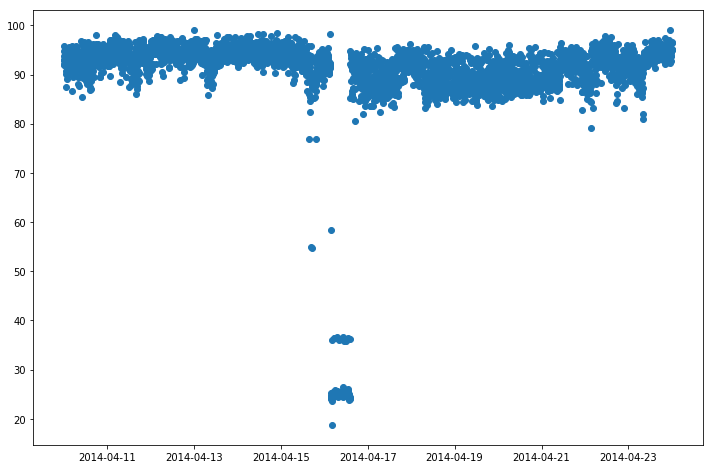

In [3]:
# I decided to use this dataset because of its distinct anomalies
# This will simplify model evaluation and comparisons

plt.rcParams['figure.figsize'] = [12, 8]
plt.plot_date(df.timestamp.values, df.value.values)
plt.show()

### Interquartile Range
The IQR anomaly detection scheme is increibly simply to understand and implement. Surprisingly, it yields some incredible results for this application. Practically all of the anomalous points were correctly identified and only a small number of nonanomalous points were incorrectly classified.

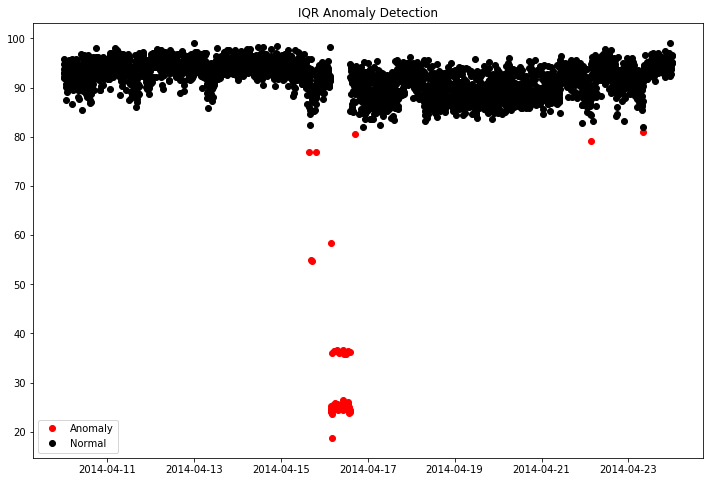

In [4]:
# Calculate IQR
q3, q1 = np.percentile(df.value.values, [75, 25])
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Record inliers and outliers
outlier_times = []
outlier_values = []
inlier_times = []
inlier_values = []

# Classify
for index, row in df.iterrows():
    if row.value < lower_bound or row.value > upper_bound:
        outlier_times.append(row.timestamp)
        outlier_values.append(row.value)
    else:
        inlier_times.append(row.timestamp)
        inlier_values.append(row.value)

# Plot results
plt.rcParams['figure.figsize'] = [12, 8]
plt.title('IQR Anomaly Detection')
plt.plot_date(outlier_times, outlier_values, color='red', label='Anomaly')
plt.plot_date(inlier_times, inlier_values, color='black', label='Normal')
plt.legend(loc='best')
plt.show()

### Isolation Forest
The isolation forest model is slightly more complicated than the IQR model. It works by constructing a random forest and classifying leaves with the shortest path as anomalies. As you can see in the resulting plot, this model is far more aggressive than the IQR model when it comes to classifying points as anomalies. While this behavior may not seem ideal for this application, the isolation forest may be far superior when detecting anomalies in another dataset.

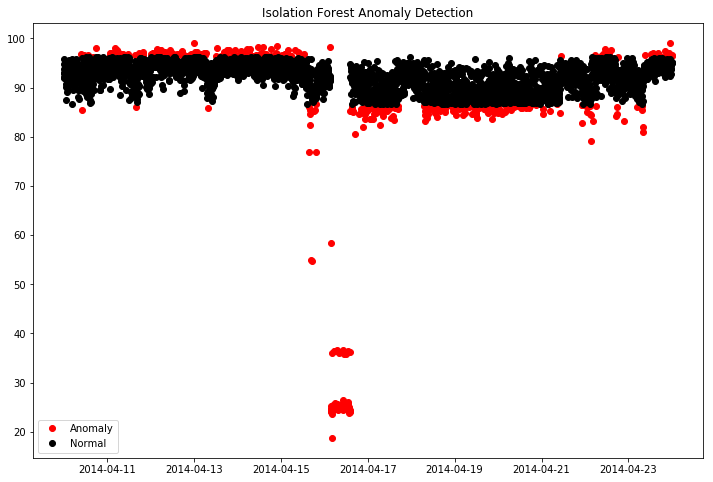

In [5]:
# Train isolation forest
values = np.array(df.value.values).reshape(-1, 1)
if_model = IsolationForest(contamination='auto', behaviour='new', random_state=0).fit(values)

# Calculate inliers and outliers
results = if_model.predict(values)

# Classify points
if_outlier_times = []
if_outlier_values = []
if_inlier_times = []
if_inlier_values = []

for index, row in df.iterrows():
    if results[index] == 1:
        if_inlier_times.append(row.timestamp)
        if_inlier_values.append(row.value)
    else:
        if_outlier_times.append(row.timestamp)
        if_outlier_values.append(row.value)       

# Plot results
plt.rcParams['figure.figsize'] = [12, 8]
plt.title('Isolation Forest Anomaly Detection')
plt.plot_date(if_outlier_times, if_outlier_values, color='red', label='Anomaly')
plt.plot_date(if_inlier_times, if_inlier_values, color='black', label='Normal')
plt.legend(loc='best')
plt.show()

### One Class SVM
Finally, I implemented a one class support vector machine. The basic idea behind this model is that, when trained on normal data, it develops an understanding of what is normal. Then, when shown new, and possibly anomalous data, the one class SVM can classify anything that doesn't share a strong resemblence to the data it was trained on. After looking at the graph, it appears this model is a happy medium between the previous two.

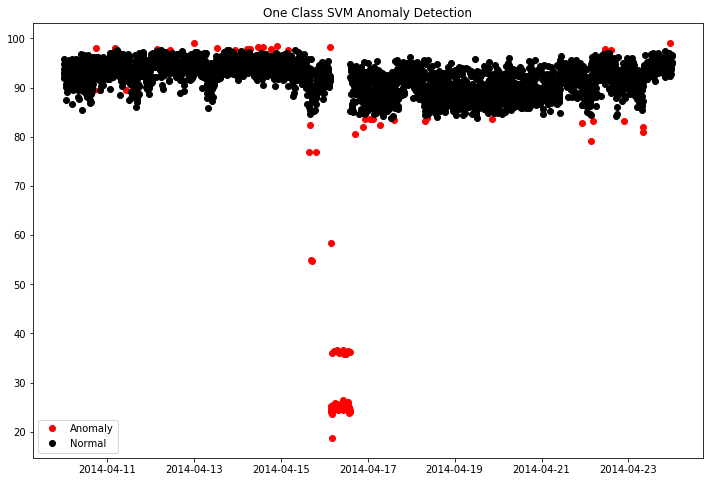

In [6]:
# Train one class svm
all_values = list(df.value.values)
normal_values = np.array(all_values[:1700] + all_values[2000:]).reshape(-1, 1)
svm = OneClassSVM(gamma=.01, nu=.01).fit(normal_values)

# Predict inliers and outliers
results = svm.predict(values)

# Categorize points
svm_outlier_times = []
svm_outlier_values = []
svm_inlier_times = []
svm_inlier_values = []

for index, row in df.iterrows():
    if results[index] == 1:
        svm_inlier_times.append(row.timestamp)
        svm_inlier_values.append(row.value)
    else:
        svm_outlier_times.append(row.timestamp)
        svm_outlier_values.append(row.value)       

# Plot results
plt.rcParams['figure.figsize'] = [12, 8]
plt.title('One Class SVM Anomaly Detection')
plt.plot_date(svm_outlier_times, svm_outlier_values, color='red', label='Anomaly')
plt.plot_date(svm_inlier_times, svm_inlier_values, color='black', label='Normal')
plt.legend(loc='best')
plt.show()

In conclusion, all three of these models were able to successfully classify the anomalies in this dataset. There were some differences between the models when it came to classifying slightly ambiguous anomalies. These different behaviors may be desirable for other applications, but it seems IQR had the best accuracy in this case.